In [1]:
from google.colab import drive
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

drive.mount('/content/drive')

tokenizer = AutoTokenizer.from_pretrained('/content/drive/My Drive/LIN371/bert-base-uncased-mlm-classifier')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/My Drive/LIN371/bert-base-uncased-mlm-classifier').bert

Mounted at /content/drive


In [2]:
import pandas as pd
exp_words = pd.read_csv('/content/drive/My Drive/LIN371/cleaned_explicit_words.csv')
exp_words_list = exp_words['text'].tolist()
exp_words_list[:5]

['69', '@55', '@sshole', '0ral seks', '0ral sex']

In [3]:
import random

def get_valid_words(tokenizer):
  vocab_keys = list(tokenizer.get_vocab().keys())
  valid_words = [
      word for word in vocab_keys
      if not word.startswith("##") and word.isalpha()
  ]
  return valid_words

def replace_words(sentence, replace_word, word_dict, n_words=50, seed=10):
    sentences = []
    new_words = []
    random.seed(seed)
    # Replace with words from word_dict
    for _ in range(n_words):
      word = random.choice(word_dict)
      new_sentence = sentence.replace(replace_word, word)
      sentences.append(new_sentence)
      new_words.append(word)

    return sentences, new_words

def forward(docs):
  inputs = tokenizer(docs, padding='max_length', max_length=512, truncation=True, return_tensors='pt')
  with torch.no_grad():
    outputs = model(**inputs)
  return outputs.last_hidden_state

def sublist_indices(lst, sublst):
    for i in range(len(lst) - len(sublst) + 1):
        if lst[i:i+len(sublst)] == sublst:
            return i
    raise Exception('what happened')

def extract_average_embeddings(docs, embeddings, replaced_words, debug=False):
  mean_embeddings = []

  for doc, word_embeddings, replaced_word in zip(docs, embeddings, replaced_words):
    doc_tok = tokenizer.tokenize(doc)
    with torch.no_grad():
      word_idx = sublist_indices(doc_tok, tokenizer.tokenize(replaced_word)) # identify the embedding of the replaced word
      if debug:
        print(doc_tok[word_idx])
      mean_embedding = word_embeddings[word_idx + 1] # cls
      n_embeddings = 1
      for i in range(word_idx+2, len(doc_tok)):
        if doc_tok[i].startswith("##"):
          if debug:
            print(doc_tok[i])
          mean_embedding += word_embeddings[i]
          n_embeddings += 1
        else:
          break
      mean_embedding /= n_embeddings
      mean_embeddings.append(mean_embedding)

  return mean_embeddings

In [9]:
text = "It's like a hundred 99 degrees When you're doing it with me, doing it with me"
clean_sentences, clean_words = replace_words(text, "doing it", get_valid_words(tokenizer), 20, seed=3)
dirty_sentences, dirty_words = replace_words(text, "doing it", exp_words_list, 20, seed=3)
clean_embeddings = forward(clean_sentences)
dirty_embeddings = forward(dirty_sentences)

In [10]:
clean_average_embeddings = extract_average_embeddings(clean_sentences, clean_embeddings, clean_words, False)
dirty_average_embeddings = extract_average_embeddings(dirty_sentences, dirty_embeddings, dirty_words, False)

In [7]:
# 12, 13
innuendo_embeddings = forward("It's like a hundred 99 degrees When you're doing it with me, doing it with me")
word_embeddings = innuendo_embeddings[0]
innuendo_average_embeddings = (word_embeddings[13] + word_embeddings[14]) / 2

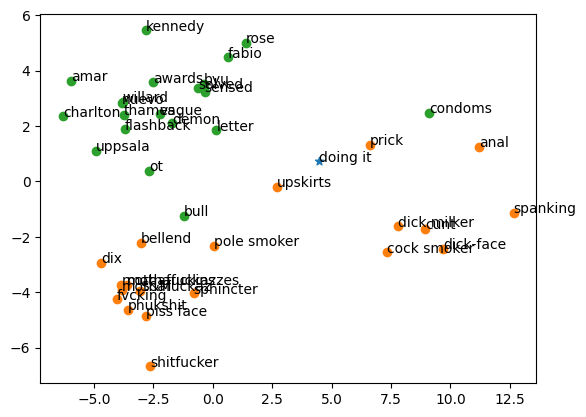

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def pca_decomposition(embeddings):
  pca = PCA(random_state=3)
  return pca.fit_transform(embeddings)

def tsne_decomposition(pca_embeddings):
  tsne = TSNE(random_state=3)
  return tsne.fit_transform(pca_embeddings)

def visualize(innuendo, exp_list, gen_list, named_words):
  # innuendo is a [1, 768] array
  # exp_list is a [batch_size, 768] array
  # gen_list is a [batch_size, 768] array
  # named_words is a [1 + batch_size + batch_size] array, the first word is the innuendo, then the explicit list, then the general list

  concat = innuendo + exp_list + gen_list
  out = pca_decomposition(concat)
  # out = tsne_decomposition(pca_decomposition(concat))

  innuendo_point = out[0]
  exp_points = out[1:1+len(exp_list)]
  gen_points = out[1+len(exp_list):]

  plt.scatter(x=innuendo_point[0], y=innuendo_point[1], marker="*")
  plt.text(x=innuendo_point[0], y=innuendo_point[1], s=named_words[0])
  plt.scatter(x=exp_points[:, 0], y=exp_points[:, 1])
  for i in range(len(exp_list)):
    plt.text(x=exp_points[i, 0], y=exp_points[i, 1], s=named_words[i+1])

  plt.scatter(x=gen_points[:, 0], y=gen_points[:, 1])
  for i in range(len(gen_list)):
    plt.text(x=gen_points[i, 0], y=gen_points[i, 1], s=named_words[1+len(exp_list)+i])

  plt.show()

# import numpy as np
# innuendo_embedding = np.random.uniform(size=(1,768)).tolist()
# exp_embedding = np.random.uniform(size=(15,768)).tolist()
# gen_embedding = np.random.uniform(size=(15,768)).tolist()
# named_words = ['innuendo'] + ['explicit'] * 15 + ['general'] * 15
# visualize(innuendo_embedding, exp_embedding, gen_embedding, named_words)
visualize([innuendo_average_embeddings], dirty_average_embeddings, clean_average_embeddings, ["doing it"] + dirty_words + clean_words)